In [16]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [60]:
# Encoder block
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    p = tf.keras.layers.MaxPooling2D((2,2))(x)
    return x, p

In [61]:
def decoder_block(inputs, skip_features, num_filters):
    # Upsample the image
    x = tf.keras.layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')(inputs)

    # Ensure skip features and x have the same dimensions
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Refine details
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

In [62]:
def unet_model(input_shape=(128,128, 3), num_classes=1):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(p4)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(b1)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(d4)

    model = tf.keras.models.Model(inputs, outputs, name='U-Net')
    return model

In [63]:
# Load and preprocess an image
def preprocess_image(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

In [64]:
# Make predictions and visualize
def predict_and_visualize(model, img_path, target_size, output_path):
    img_array, org_img = preprocess_image(img_path, target_size)
    prediction = model.predict(img_array)
    prediction = np.squeeze(prediction) #Remove batch dimension
    prediction = (prediction > 0.5).astype(np.uint8) #Threshold the o/p img_array pred

    # Convert prediction to animage
    predicted_img = Image.fromarray((prediction * 255).astype(np.uint8))
    predicted_img = predicted_img.resize(org_img.size) #Resize to original image
    predicted_img.save(output_path)

    # Display the images
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(org_img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Predicted Image")
    plt.imshow(predicted_img, cmap="gray")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


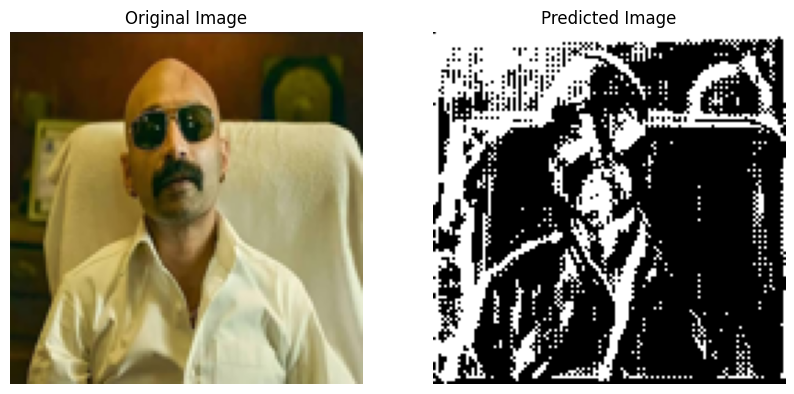

In [65]:
# Example usage
if __name__=="__main__":
    # Define the U-Net model
    model = unet_model(input_shape=(128,128,3), num_classes=1)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

    # Dummy model loading for demo (use your own weights)
    img_path = r"C:\Users\vamsh\Pictures\party_ledha _pushpa.jpg"
    output_path = 'predicted_image.jpg'
    predict_and_visualize(model, img_path, target_size=(128,128), output_path= output_path)